In [1]:
import pandas as pd
from numpy import random

from consts import default_random_seed
from policy import policy_treat_by_D_cate, policy_treat_by_ignoring_trunc, policy_treat_by_composite_outcome, \
    policy_treat_by_zr_bounds
from sample_generation import create_sample, data_adjustments, \
    adjust_data_with_beta_estimations, simulate_counterfactuals
from strata import Strata
from zhang_rubin_help_func import calc_non_parametric_zhang_rubin, calc_zhang_rubin_bounds_analytically, plot_zhang_rubin_bounds_on_survivors, \
    train_superquantile_model, calc_zhang_rubin_bounds_using_cvar_est, plot_zhang_rubin_bounds_no_x
random.seed(default_random_seed)

In [2]:
# rwd = data_adjustments(dataset='lalonde') # RWD = Real World Data set
rwd = data_adjustments(dataset='STAR') # RWD = Real World Data set

# $Y(t)|X,S_t=1$


In [3]:
# sample_for_y_dist = create_sample(
#     y0_dist_param ={'a0': 0.0, 'b0': 2.0, 'c0': 100.0, 'sigma_01': 1, 'sigma_00': 1} , 
#     y1_dist_param = {'a1': 0.0, 'b1': 4.0, 'c1': 100.0, 'sigma_11': 1, 'sigma_10': 1})

sample_for_y_dist = create_sample()
sample_for_y_dist_s = sample_for_y_dist.loc[sample_for_y_dist.D_obs==0] # survivers only


In [4]:
print("\nExample from each strata:")
display(sample_for_y_dist.groupby("stratum").sample(n=3, random_state=1))


Example from each strata:


,x,t,D0,D1,p_t0d0_x,p_t1d0_x,stratum,S1,S0,Y0,...,mu0,mu1,sigma_0,sigma_1,a0,b0,c0,a1,b1,c1
7918,-0.772476,0,0,0,0.941170,0.991612,AS,1.0,1.0,10.023207,...,8.455048,6.910096,1,1,0.0,2.0,10.0,0.0,4.0,10.0
4441,0.661246,0,0,0,0.792285,0.965735,AS,1.0,1.0,11.454635,...,11.322491,12.644982,1,1,0.0,2.0,10.0,0.0,4.0,10.0
7416,-0.390478,1,0,0,0.916098,0.987757,AS,1.0,1.0,10.409915,...,9.219044,8.438087,1,1,0.0,2.0,10.0,0.0,4.0,10.0
3417,0.308684,1,1,1,0.844397,0.975668,D,NaN,NaN,NaN,...,NaN,NaN,1,1,0.0,2.0,10.0,0.0,4.0,10.0
9948,0.022873,0,1,1,0.878375,0.981605,D,NaN,NaN,NaN,...,NaN,NaN,1,1,0.0,2.0,10.0,0.0,4.0,10.0
5502,-0.534283,0,1,1,0.926511,0.989379,D,NaN,NaN,NaN,...,NaN,NaN,1,1,0.0,2.0,10.0,0.0,4.0,10.0
1133,-0.559634,1,0,1,0.928218,0.989643,H,NaN,0.0,-0.318115,...,-1.119267,NaN,1,1,0.0,2.0,10.0,0.0,4.0,10.0
3691,0.049471,0,0,1,0.875504,0.981119,H,NaN,0.0,-0.175954,...,0.098943,NaN,1,1,0.0,2.0,10.0,0.0,4.0,10.0
9260,-0.092492,0,0,1,0.890171,0.983577,H,NaN,0.0,0.499586,...,-0.184985,NaN,1,1,0.0,2.0,10.0,0.0,4.0,10.0
7049,-0.025835,0,1,0,0.883483,0.982464,P,0.0,NaN,NaN,...,NaN,-0.103340,1,1,0.0,2.0,10.0,0.0,4.0,10.0


## Using observational data:
0.   Naive ATE
1.   Zhang & Rubin
2.   Using the parametric assumptions - Y is normal, estimate mu out of two mixed gaussians that differ by one latent variable

### 0. Naive ATE

##### Simulated Data

In [5]:
print(f"Naive ATE for Y: {round(sample_for_y_dist.Y1.mean() - sample_for_y_dist.Y0.mean(),2)}")
print(f"ATE for D: {round(sample_for_y_dist.D1.mean() - sample_for_y_dist.D0.mean(),2)}")

Naive ATE for Y: -1.05
ATE for D: -0.11


##### rwd

In [6]:
print(f"Naive ATE for Y: {round(rwd.loc[rwd.t==1].Y_obs.mean() - rwd.loc[rwd.t==0].Y_obs.mean(),2)}")
print(f"ATE for D: {round(rwd.loc[rwd.t==1].D_obs.mean() - rwd.loc[rwd.t==0].D_obs.mean(),2)}")

Naive ATE for Y: 0.07
ATE for D: -0.03


### 1. Zhang & Rubin

#### Non parametric

##### Simulated Data

In [7]:
zhang_rubin_lb, zhang_rubin_ub = calc_non_parametric_zhang_rubin(sample_for_y_dist)
print(f"Bounds by Zhang and Rubin: [{zhang_rubin_lb}, {zhang_rubin_ub}]")
as_df = sample_for_y_dist.loc[sample_for_y_dist.stratum==Strata.AS.name]
print(f"Actual AS treatment effect: {(as_df.Y1-as_df.Y0).mean()}")

Bounds by Zhang and Rubin: [-1.963831565780759, 0.2792491148288061]
Actual AS treatment effect: -0.09352604936304877


##### RWD = Real World Data set

In [8]:
zhang_rubin_lb_rwd, zhang_rubin_ub_rwd = calc_non_parametric_zhang_rubin(rwd)
print(f"Bounds by Zhang and Rubin: [{zhang_rubin_lb_rwd}, {zhang_rubin_ub_rwd}]")

Bounds by Zhang and Rubin: [-0.2959331517655422, 0.4347370777402621]


##### using CVaR

In [9]:
cvar_model_trained_simu_treated, cvar_model_trained_simu_untreated = train_superquantile_model(sample_for_y_dist[['x','D_obs','Y_obs','t']])

In [10]:
zhang_rubin_bounds_cvar = calc_zhang_rubin_bounds_using_cvar_est(sample_for_y_dist_s[['x','D_obs','Y_obs','t', 'p_t0d0_x', 'p_t1d0_x']], cvar_model_trained_simu_treated, cvar_model_trained_simu_untreated)

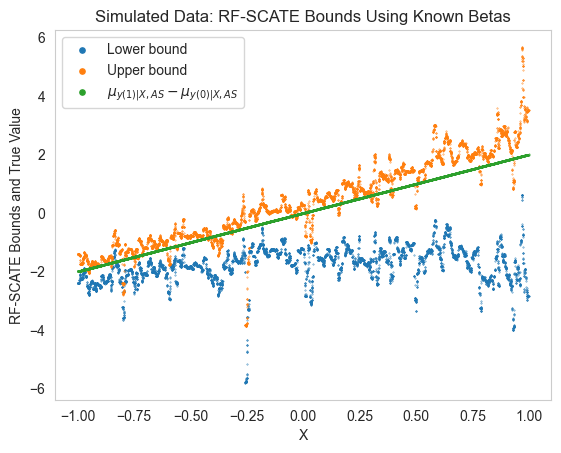

In [11]:
zhang_rubin_bounds_cvar_inc_x_and_cate = plot_zhang_rubin_bounds_on_survivors(sample_for_y_dist_s, zhang_rubin_bounds_cvar, title="Simulated Data: RF-SCATE Bounds Using Known Betas", y_title= "RF-SCATE Bounds and True Value")

###### CVaR Without using simulated 'p_t0d0_x', 'p_t1d0_x', but estimating them (estimating beta)


In [12]:
sample_for_y_dist_hat = adjust_data_with_beta_estimations(sample_for_y_dist)
sample_for_y_dist_hat_s = sample_for_y_dist_hat.loc[sample_for_y_dist_hat.D_obs==0]

beta_d_hat: [-1.95, -2.12, 0.94]
(True beta_d: [-2.0, -2.0, 1.0])


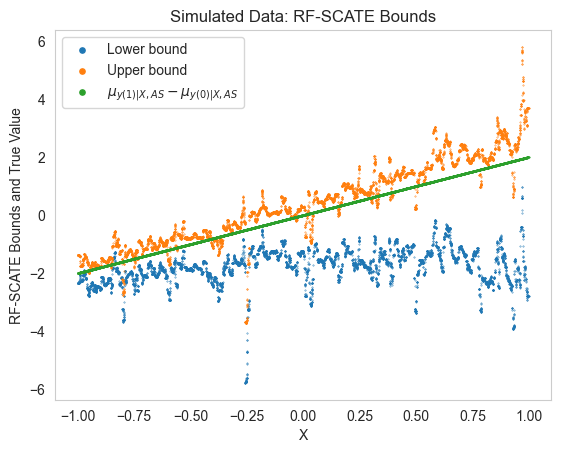

In [13]:
zhang_rubin_bounds_cvar_hat = calc_zhang_rubin_bounds_using_cvar_est(sample_for_y_dist_hat_s, cvar_model_trained_simu_treated, cvar_model_trained_simu_untreated)
zhang_rubin_bounds_cvar_hat_inc_x_and_cate = plot_zhang_rubin_bounds_on_survivors(sample_for_y_dist_s, zhang_rubin_bounds_cvar_hat, title="Simulated Data: RF-SCATE Bounds", y_title= "RF-SCATE Bounds and True Value")

###### RWD

In [14]:
print(f"Out of the {rwd.shape[0]} samples participated in this analysis, {rwd.loc[rwd.D_obs==1].shape[0]} were truncated ({round(100*rwd.loc[rwd.D_obs==1].shape[0]/rwd.shape[0],1)}%).")
print(f"Among the {rwd.loc[rwd.t==1].shape[0]} that were assigned to small class ($T=1$), {rwd.loc[(rwd.t==1)&(rwd.D_obs==1)].shape[0]} were truncated ({round(100*rwd.loc[(rwd.t==1)&(rwd.D_obs==1)].shape[0]/rwd.loc[rwd.t==1].shape[0],1)}%).")
print(f"Among the {rwd.loc[rwd.t==0].shape[0]} that were assigned to regular or regular with aid class ($T=0$), {rwd.loc[(rwd.t==0)&(rwd.D_obs==1)].shape[0]} were truncated ({round(100*rwd.loc[(rwd.t==0)&(rwd.D_obs==1)].shape[0]/rwd.loc[rwd.t==0].shape[0],1)}%).")

Out of the 5916 samples participated in this analysis, 1810 were truncated (30.6%).
Among the 1776 that were assigned to small class ($T=1$), 500 were truncated (28.2%).
Among the 4140 that were assigned to regular or regular with aid class ($T=0$), 1310 were truncated (31.6%).


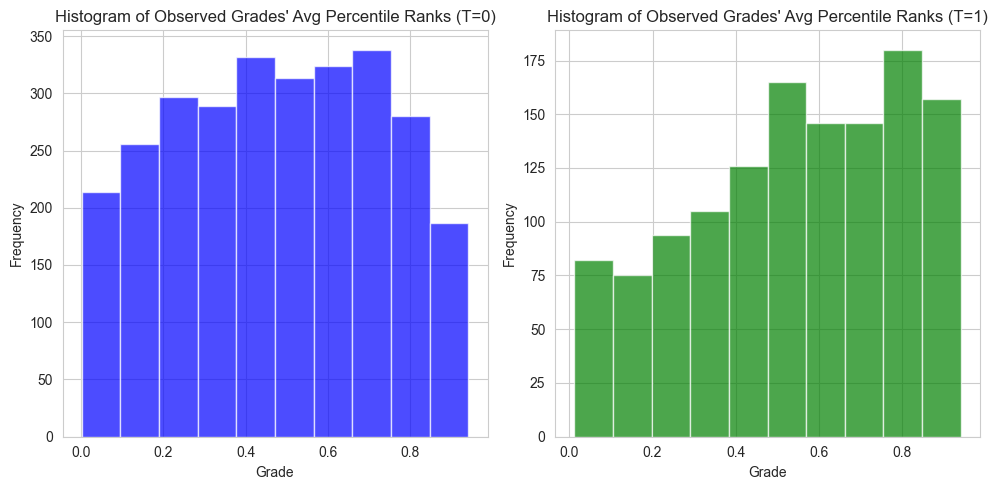

In [15]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Histogram of the observed grades under T=0
axs[0].hist(rwd.loc[rwd.t==0].Y_obs, bins=10, color='blue', alpha=0.7)
axs[0].set_title('Histogram of Observed Grades\' Avg Percentile Ranks (T=0)')
axs[0].set_xlabel('Grade')
axs[0].set_ylabel('Frequency')

# Histogram of the observed grades under T=1
axs[1].hist(rwd.loc[rwd.t==1].Y_obs, bins=10, color='green', alpha=0.7)
axs[1].set_title('Histogram of Observed Grades\' Avg Percentile Ranks (T=1)')
axs[1].set_xlabel('Grade')
axs[1].set_ylabel('Frequency')

plt.tight_layout()

In [16]:
cvar_model_trained_rwd_treated, cvar_model_trained_rwd_untreated = train_superquantile_model(rwd[['x','D_obs','Y_obs','t']])

In [17]:
rwd_hat = adjust_data_with_beta_estimations(rwd)

beta_d_hat: [0.34, -0.14, 0.37, -0.14, -0.16, -0.14, -0.34, -0.0, -0.02, 0.0]


In [18]:
rwd_hat_s = rwd_hat.loc[rwd_hat.D_obs==0].reset_index()
zhang_rubin_bounds_cvar_hat_rwd = calc_zhang_rubin_bounds_using_cvar_est(rwd_hat_s, cvar_model_trained_rwd_treated, cvar_model_trained_rwd_untreated)

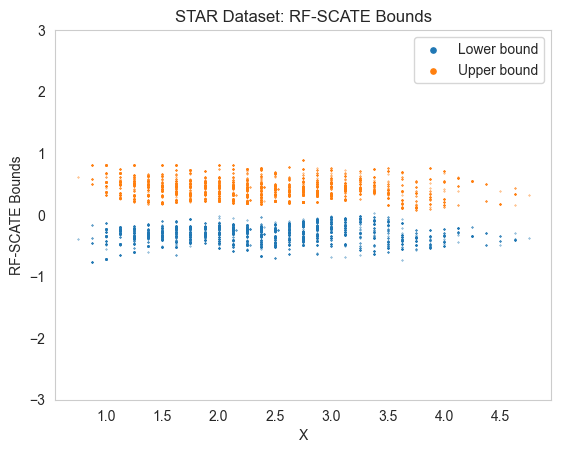

In [19]:
zhang_rubin_bounds_cvar_hat_rwd_inc_x_and_cate = plot_zhang_rubin_bounds_on_survivors(rwd_hat_s, zhang_rubin_bounds_cvar_hat_rwd, title="STAR Dataset: RF-SCATE Bounds", y_title= "RF-SCATE Bounds", plot_graph_margin=True)

1 positive bounds (0.024%)
0 negative bounds (0.0%)


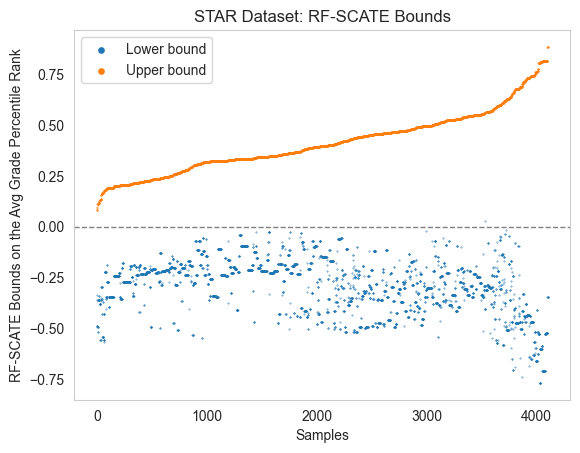

In [20]:
plot_zhang_rubin_bounds_no_x(zhang_rubin_bounds_cvar_hat_rwd_inc_x_and_cate, title="STAR Dataset: RF-SCATE Bounds", y_title= "RF-SCATE Bounds on the Avg Grade Percentile Rank", plot_horizontal_zero=True)

In [21]:
rwd_semi_simulated = simulate_counterfactuals(rwd)
rwd_semi_simulated_s = rwd_semi_simulated.loc[rwd_semi_simulated.D_obs==0]

           counts  percentage
Strata.AS    2822   47.701149
Strata.P     1325   22.396890
Strata.H     1180   19.945909
Strata.D      589    9.956051


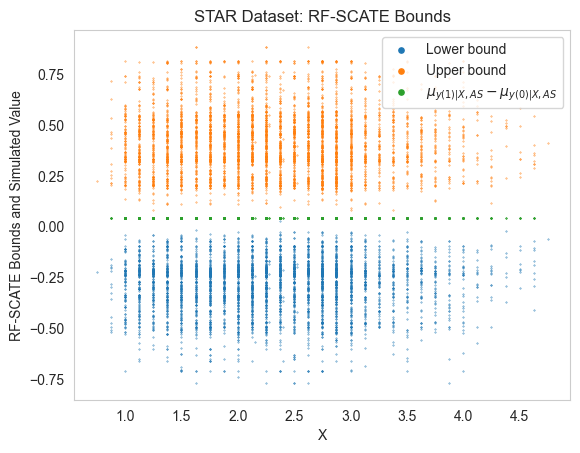

In [22]:
zhang_rubin_bounds_cvar_hat_rwd_semi_simulated_inc_x_and_cate = plot_zhang_rubin_bounds_on_survivors(rwd_semi_simulated_s, zhang_rubin_bounds_cvar_hat_rwd, title="STAR Dataset: RF-SCATE Bounds", y_title= "RF-SCATE Bounds and Simulated Value")

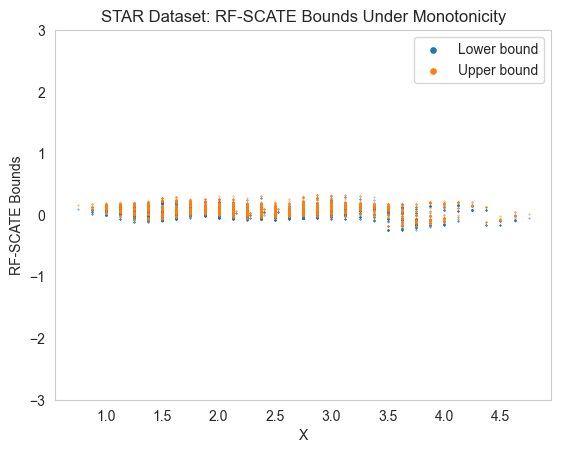

In [23]:
zhang_rubin_bounds_cvar_hat_rwd_mono = calc_zhang_rubin_bounds_using_cvar_est(rwd_hat_s, cvar_model_trained_rwd_treated, cvar_model_trained_rwd_untreated, monotonicity_assumption=True)
zhang_rubin_bounds_cvar_hat_rwd_mono_inc_x_and_cate = plot_zhang_rubin_bounds_on_survivors(rwd_hat_s, zhang_rubin_bounds_cvar_hat_rwd_mono, title="STAR Dataset: RF-SCATE Bounds Under Monotonicity", y_title= "RF-SCATE Bounds", plot_graph_margin=True)

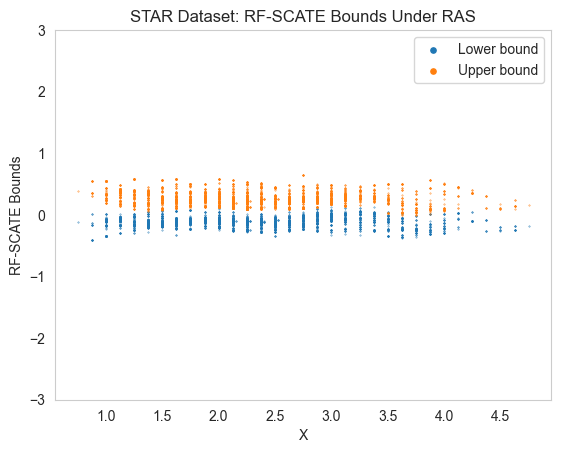

In [24]:
zhang_rubin_bounds_cvar_hat_rwd_ras = calc_zhang_rubin_bounds_using_cvar_est(rwd_hat_s, cvar_model_trained_rwd_treated, cvar_model_trained_rwd_untreated, ras_assumption=True)
zhang_rubin_bounds_cvar_hat_rwd_ras_inc_x_and_cate = plot_zhang_rubin_bounds_on_survivors(rwd_hat_s, zhang_rubin_bounds_cvar_hat_rwd_ras, title="STAR Dataset: RF-SCATE Bounds Under RAS", y_title= "RF-SCATE Bounds", plot_graph_margin=True)

2950 positive bounds (71.846%)
487 negative bounds (11.861%)


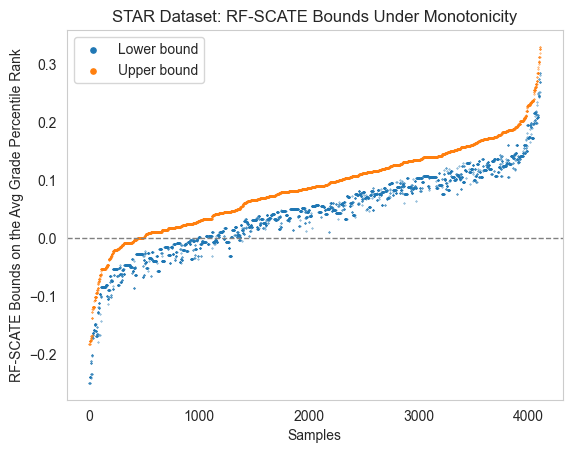

In [25]:
plot_zhang_rubin_bounds_no_x(zhang_rubin_bounds_cvar_hat_rwd_mono_inc_x_and_cate, title="STAR Dataset: RF-SCATE Bounds Under Monotonicity", y_title= "RF-SCATE Bounds on the Avg Grade Percentile Rank", plot_horizontal_zero=True)

317 positive bounds (7.72%)
3 negative bounds (0.073%)


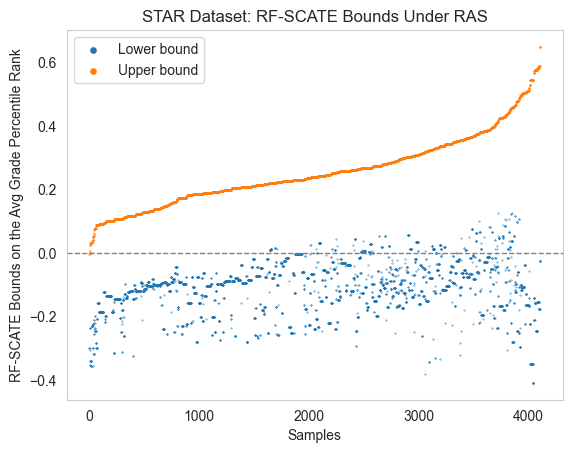

In [26]:
plot_zhang_rubin_bounds_no_x(zhang_rubin_bounds_cvar_hat_rwd_ras_inc_x_and_cate, title="STAR Dataset: RF-SCATE Bounds Under RAS", y_title= "RF-SCATE Bounds on the Avg Grade Percentile Rank", plot_horizontal_zero=True)

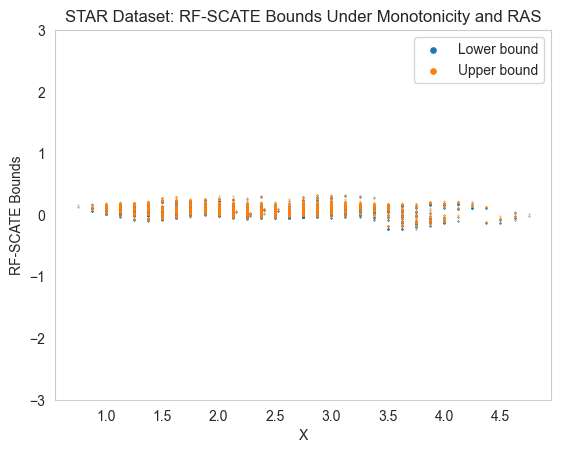

In [27]:
zhang_rubin_bounds_cvar_hat_rwd_mono_ras = calc_zhang_rubin_bounds_using_cvar_est(rwd_hat_s, cvar_model_trained_rwd_treated, cvar_model_trained_rwd_untreated, monotonicity_assumption=True, ras_assumption=True)
zhang_rubin_bounds_cvar_hat_rwd_mono_ras_inc_x_and_cate = plot_zhang_rubin_bounds_on_survivors(rwd_hat_s, zhang_rubin_bounds_cvar_hat_rwd_mono_ras, title="STAR Dataset: RF-SCATE Bounds Under Monotonicity and RAS", y_title= "RF-SCATE Bounds", plot_graph_margin=True)

3278 positive bounds (79.834%)
487 negative bounds (11.861%)


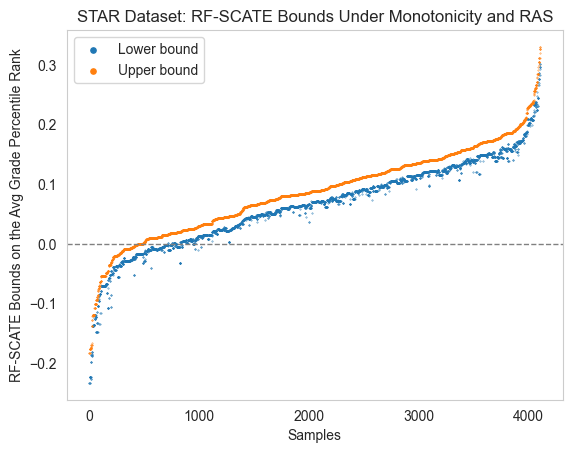

In [28]:
plot_zhang_rubin_bounds_no_x(zhang_rubin_bounds_cvar_hat_rwd_mono_ras_inc_x_and_cate, title="STAR Dataset: RF-SCATE Bounds Under Monotonicity and RAS", y_title= "RF-SCATE Bounds on the Avg Grade Percentile Rank", plot_horizontal_zero=True)

### Policy Values on semi simulated dataset

In [29]:
policy_value_y, policy_value_d, policy_value_y_as = policy_treat_by_D_cate(rwd_semi_simulated)
print(f"Policy value for Y: {policy_value_y}, for survival ratio: {policy_value_d}, for Y of AS: {policy_value_y_as}")

Policy value for Y: 0.5310837891122426, for survival ratio: 0.7018255578093306, for Y of AS: 0.5598859892213721


In [30]:
policy_value_y, policy_value_d, policy_value_y_as = policy_treat_by_ignoring_trunc(rwd_semi_simulated)
print(f"Policy value for Y: {policy_value_y}, for survival ratio: {policy_value_d}, for Y of AS: {policy_value_y_as}")

Policy value for Y: 0.5483747924902787, for survival ratio: 0.6957403651115619, for Y of AS: 0.5735072875093634


In [31]:
policy_value_y, policy_value_d, policy_value_y_as = policy_treat_by_composite_outcome(rwd_semi_simulated)
print(f"Policy value for Y: {policy_value_y}, for survival ratio: {policy_value_d}, for Y of AS: {policy_value_y_as}")

Policy value for Y: 0.5130933172771023, for survival ratio: 0.6959093982420554, for Y of AS: 0.5379256515987944


In [32]:
rwd_hat_semi_simulated = adjust_data_with_beta_estimations(rwd_semi_simulated[['x','t','D_obs','Y_obs']])
lb, ub = calc_zhang_rubin_bounds_using_cvar_est(rwd_hat_semi_simulated, cvar_model_trained_rwd_treated, cvar_model_trained_rwd_untreated)
policy_value_y, policy_value_d, policy_value_y_as = policy_treat_by_zr_bounds(rwd_semi_simulated, lb, ub, lb_threshold=-0.65)
print(f"Policy value for Y: {policy_value_y}, for survival ratio: {policy_value_d}, for Y of AS: {policy_value_y_as}")

beta_d_hat: [0.34, -0.14, 0.37, -0.14, -0.16, -0.14, -0.34, -0.0, -0.02, 0.0]
Policy value for Y: 0.5304503375570093, for survival ratio: 0.6984448951994591, for Y of AS: 0.5580132794749875


#### Policy values using assumptions

##### Monotonicity

In [33]:
rwd_semi_simulated_mono = simulate_counterfactuals(rwd, mono=True)
rwd_semi_simulated_mono_s = rwd_semi_simulated_mono.loc[rwd_semi_simulated_mono.D_obs==0]

           counts  percentage
Strata.AS    3674   62.102772
Strata.P     1325   22.396890
Strata.D      917   15.500338


In [34]:
policy_value_y, policy_value_d, policy_value_y_as = policy_treat_by_D_cate(rwd_semi_simulated_mono)
print(f"Policy value for Y: {policy_value_y}, for survival ratio: {policy_value_d}, for Y of AS: {policy_value_y_as}")

Policy value for Y: 0.5629260225203889, for survival ratio: 0.8443204868154158, for Y of AS: 0.5965984067291129


In [35]:
rwd_hat_semi_simulated_mono = adjust_data_with_beta_estimations(rwd_semi_simulated_mono[['x', 't', 'D_obs', 'Y_obs']])
lb, ub = calc_zhang_rubin_bounds_using_cvar_est(rwd_hat_semi_simulated_mono, cvar_model_trained_rwd_treated, cvar_model_trained_rwd_untreated, monotonicity_assumption=True)
policy_value_y, policy_value_d, policy_value_y_as = policy_treat_by_zr_bounds(rwd_semi_simulated_mono, lb, ub)
print(f"Policy value for Y: {policy_value_y}, for survival ratio: {policy_value_d}, for Y of AS: {policy_value_y_as}")

beta_d_hat: [0.34, -0.14, 0.37, -0.14, -0.16, -0.14, -0.34, -0.0, -0.02, 0.0]
Policy value for Y: 0.5630998350274931, for survival ratio: 0.8449966193373901, for Y of AS: 0.5968962124334242


##### Ranked Average Score

In [36]:
rwd_semi_simulated_ras = simulate_counterfactuals(rwd, ras=True)
rwd_semi_simulated_ras_s = rwd_semi_simulated_ras.loc[rwd_semi_simulated_ras.D_obs==0]

           counts  percentage
Strata.AS    2822   47.701149
Strata.P     1325   22.396890
Strata.H     1180   19.945909
Strata.D      589    9.956051


In [37]:
policy_value_y, policy_value_d, policy_value_y_as = policy_treat_by_D_cate(rwd_semi_simulated_ras)
print(f"Policy value for Y: {policy_value_y}, for survival ratio: {policy_value_d}, for Y of AS: {policy_value_y_as}")

Policy value for Y: 0.5310837891122426, for survival ratio: 0.7018255578093306, for Y of AS: 0.5598859892213721


In [38]:
rwd_hat_semi_simulated_ras = adjust_data_with_beta_estimations(rwd_semi_simulated_ras[['x', 't', 'D_obs', 'Y_obs']])
lb, ub = calc_zhang_rubin_bounds_using_cvar_est(rwd_hat_semi_simulated_ras, cvar_model_trained_rwd_treated, cvar_model_trained_rwd_untreated, ras_assumption=True)
policy_value_y, policy_value_d, policy_value_y_as = policy_treat_by_zr_bounds(rwd_semi_simulated_ras, lb, ub)
print(f"Policy value for Y: {policy_value_y}, for survival ratio: {policy_value_d}, for Y of AS: {policy_value_y_as}")

beta_d_hat: [0.34, -0.14, 0.37, -0.14, -0.16, -0.14, -0.34, -0.0, -0.02, 0.0]
Policy value for Y: 0.5337888040506612, for survival ratio: 0.6935429344151454, for Y of AS: 0.5614352417973599


#### Parametric

Lower bound:
$min_{\pi_h}\left[ \bar{Y}^{obs}(1)_{\left[0,\frac{P_{T=0,D=0}}{P_{T=1,D=0}}-\frac{\pi_h}{P_{T=1,D=0}}\right]} - \bar{Y}^{obs}(0)_{\left[\frac{\pi_h}{P_{T=0,D=0}},1\right]} \right]$ <br>
Upper bound:
$max_{\pi_h}\left[ \bar{Y}^{obs}(1)_{\left[1-\frac{P_{T=0,D=0}}{P_{T=1,D=0}}+\frac{\pi_h}{P_{T=1,D=0}},1\right]} - \bar{Y}^{obs}(0)_{\left[0,1-\frac{\pi_h}{P_{T=0,D=0}}\right]} \right]$

<br><br>


$\Rightarrow\bar{Y}^{obs}(1)_{\left[0,\frac{P_{T=0,D=0}}{P_{T=1,D=0}}-\frac{\pi_h}{P_{T=1,D=0}}\right]} \rightarrow
\frac{\pi_P}{\pi_{P}+\pi_{AS}}\cdot \frac{1}{\frac{P_{T=0,D=0}}{P_{T=1,D=0}}-\frac{\pi_h}{P_{T=1,D=0}}} \cdot
\int_{F_{Y_{(1)}}^{-1}(0)}^{F_{Y_{(1)}}^{-1}\left(\frac{P_{T=0,D=0}}{P_{T=1,D=0}}-\frac{\pi_h}{P_{T=1,D=0}}\right)}
y\cdot\frac{1}{\sigma_{Y_{(1)}}\sqrt{2\pi}}
  \exp\left( -\frac{1}{2}\left(\frac{y-\mu^{P}_{Y_{(1)}}}{\sigma_{Y_{(1)}}}\right)^{\!2}\,\right)\,\cdot dy
  + \frac{\pi_{AS}}{\pi_{P}+\pi_{AS}}\cdot \frac{1}{\frac{P_{T=0,D=0}}{P_{T=1,D=0}}-\frac{\pi_h}{P_{T=1,D=0}}} \cdot
  \int_{F_{Y_{(1)}}^{-1}(0)}^{F_{Y_{(1)}}^{-1}\left(\frac{P_{T=0,D=0}}{P_{T=1,D=0}}-\frac{\pi_h}{P_{T=1,D=0}}\right)}
y\cdot\frac{1}{\sigma_{Y_{(1)}}\sqrt{2\pi}}
  \exp\left( -\frac{1}{2}\left(\frac{y-\mu^{AS}_{Y_{(1)}}}{\sigma_{Y_{(1)}}}\right)^{\!2}\,\right)\,\cdot dy$

<br>

$\Rightarrow\bar{Y}^{obs}(1)_{\left[1-\frac{P_{T=0,D=0}}{P_{T=1,D=0}}+\frac{\pi_h}{P_{T=1,D=0}},1\right]} \rightarrow
\frac{\pi_P}{\pi_{P}+\pi_{AS}}\cdot \frac{1}{\frac{P_{T=0,D=0}}{P_{T=1,D=0}}-\frac{\pi_h}{P_{T=1,D=0}}} \cdot
\int_{F_{Y_{(1)}}^{-1}\left(1-\frac{P_{T=0,D=0}}{P_{T=1,D=0}}+\frac{\pi_h}{P_{T=1,D=0}}\right)}^{F_{Y_{(1)}}^{-1}(1)}
y\cdot\frac{1}{\sigma_{Y_{(1)}}\sqrt{2\pi}}
  \exp\left( -\frac{1}{2}\left(\frac{y-\mu^{P}_{Y_{(1)}}}{\sigma_{Y_{(1)}}}\right)^{\!2}\,\right)\,\cdot dy
  + \frac{\pi_{AS}}{\pi_{P}+\pi_{AS}}\cdot \frac{1}{\frac{P_{T=0,D=0}}{P_{T=1,D=0}}-\frac{\pi_h}{P_{T=1,D=0}}} \cdot
  \int_{F_{Y_{(1)}}^{-1}\left(1-\frac{P_{T=0,D=0}}{P_{T=1,D=0}}+\frac{\pi_h}{P_{T=1,D=0}}\right)}^{F_{Y_{(1)}}^{-1}(1)}
y\cdot\frac{1}{\sigma_{Y_{(1)}}\sqrt{2\pi}}
  \exp\left( -\frac{1}{2}\left(\frac{y-\mu^{AS}_{Y_{(1)}}}{\sigma_{Y_{(1)}}}\right)^{\!2}\,\right)\,\cdot dy$
<br>
$\Rightarrow\bar{Y}^{obs}(0)_{\left[\frac{\pi_h}{P_{T=0,D=0}},1\right]} \rightarrow
\frac{\pi_H}{\pi_{H}+\pi_{AS}}\cdot \frac{1}{1-\frac{\pi_h}{P_{T=0,D=0}}} \cdot
\int_{F_{Y_{(0)}}^{-1}\left(\frac{\pi_h}{P_{T=0,D=0}}\right)}^{F_{Y_{(0)}}^{-1}(1)}
y\cdot\frac{1}{\sigma_{Y_{(0)}}\sqrt{2\pi}}
  \exp\left( -\frac{1}{2}\left(\frac{y-\mu^{H}_{Y_{(0)}}}{\sigma_{Y_{(0)}}}\right)^{\!2}\,\right)\,\cdot dy
  + \frac{\pi_{AS}}{\pi_{H}+\pi_{AS}}\cdot \frac{1}{1-\frac{\pi_h}{P_{T=0,D=0}}} \cdot
  \int_{F_{Y_{(0)}}^{-1}\left(\frac{\pi_h}{P_{T=0,D=0}}\right)}^{F_{Y_{(0)}}^{-1}(1)}
y\cdot\frac{1}{\sigma_{Y_{(0)}}\sqrt{2\pi}}
  \exp\left( -\frac{1}{2}\left(\frac{y-\mu^{AS}_{Y_{(0)}}}{\sigma_{Y_{(0)}}}\right)^{\!2}\,\right)\,\cdot dy$
<br>
$\Rightarrow\bar{Y}^{obs}(0)_{\left[0,1-\frac{\pi_h}{P_{T=0,D=0}}\right]} \rightarrow
\frac{\pi_H}{\pi_{H}+\pi_{AS}}\cdot \frac{1}{1-\frac{\pi_h}{P_{T=0,D=0}}}\cdot
\int_{F_{Y_{(0)}}^{-1}\left(0\right)}^{F_{Y_{(0)}}^{-1}\left(1-\frac{\pi_h}{P_{T=0,D=0}}\right)}
y\cdot\frac{1}{\sigma_{Y_{(0)}}\sqrt{2\pi}}
  \exp\left( -\frac{1}{2}\left(\frac{y-\mu^{H}_{Y_{(0)}}}{\sigma_{Y_{(0)}}}\right)^{\!2}\,\right)\,\cdot dy
  + \frac{\pi_{AS}}{\pi_{H}+\pi_{AS}}\cdot \frac{1}{1-\frac{\pi_h}{P_{T=0,D=0}}}\cdot
  \int_{F_{Y_{(0)}}^{-1}\left(0\right)}^{F_{Y_{(0)}}^{-1}\left(1-\frac{\pi_h}{P_{T=0,D=0}}\right)}
y\cdot\frac{1}{\sigma_{Y_{(0)}}\sqrt{2\pi}}
  \exp\left( -\frac{1}{2}\left(\frac{y-\mu^{AS}_{Y_{(0)}}}{\sigma_{Y_{(0)}}}\right)^{\!2}\,\right)\,\cdot dy$

Note that the weights are identifiable from observational data:
$\frac{\pi_{P}}{\pi_{P}+\pi_{AS}}=\left(1-\frac{P_{T=0,D=0}}{P_{T=1,D=0}}+\frac{\pi_h}{P_{T=1,D=0}}\right)$ <br>
$\frac{\pi_{H}}{\pi_{H}+\pi_{AS}}=\left(\frac{\pi_h}{P_{T=0,D=0}}\right)$

<br>
$F_{Y_{(1)}}^{-1}(\alpha)=P(Y_{(1)}<F^{-1}(\alpha))$ where $F^{-1}(\alpha)$ is the $\alpha$ quantile of $Y_{(1)}$. Although quantile function for mixed Gaussians does not admit a closed-form expression, it can be calculated. First we'll calculate the quantile using binary search, and then we'll calculate the cdf of that quantile.

##### For 40 samples, plot $\pi_h$, parametric bounds for each $\pi_h$, final parametric and non parametric bounds

In [39]:
# pi_h_and_bounds_plots_controller(sample_for_y_dist)

TODO - Note that some pi's don't have the integral solution <br>
TODO - check the $\mu$ inside the integral vs outside, should be the same (for given bounds)<br>

In [40]:
zhang_rubin_bounds_analytic = calc_zhang_rubin_bounds_analytically(sample_for_y_dist_s)

row 0 out of 9238
row 1000 out of 9238
row 2000 out of 9238
row 3000 out of 9238
row 4000 out of 9238
row 5000 out of 9238
row 6000 out of 9238
row 7000 out of 9238
row 8000 out of 9238
row 9000 out of 9238


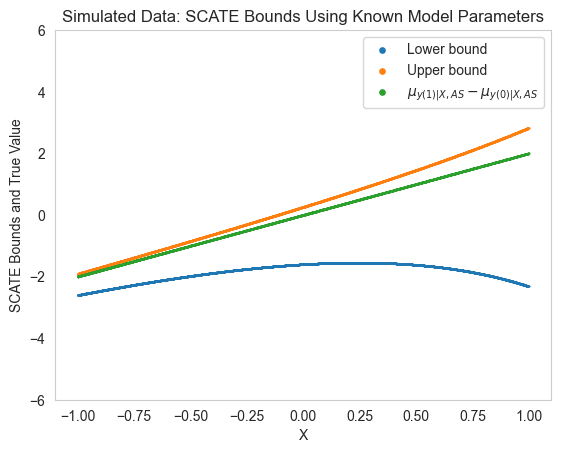

In [41]:
zr_bounds_analytic = plot_zhang_rubin_bounds_on_survivors(sample_for_y_dist_s, zhang_rubin_bounds_analytic, title="Simulated Data: SCATE Bounds Using Known Model Parameters", y_title= "SCATE Bounds and True Value", plot_graph_margin=True, ylim_margin=6)

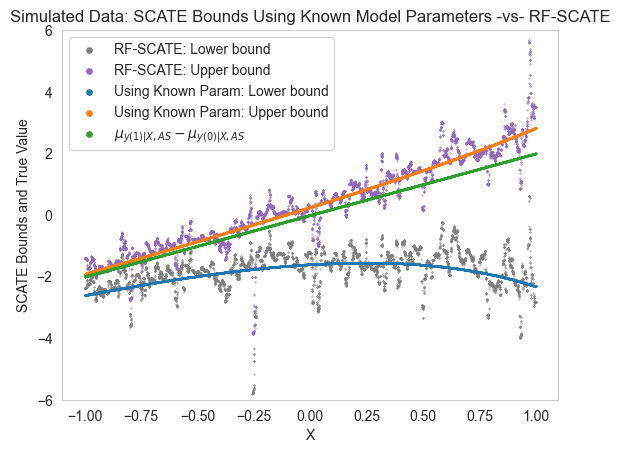

In [42]:
import matplotlib.pyplot as plt

df_plot_as = sample_for_y_dist_s.loc[sample_for_y_dist_s.stratum == Strata.AS.name]
# plt.scatter(df_plot_as.x, (df_plot_as.Y1 - df_plot_as.Y0), label="True Y1 - Y0|AS", s=0.1)

plt.scatter(list(zhang_rubin_bounds_cvar_inc_x_and_cate['x']), zhang_rubin_bounds_cvar_inc_x_and_cate['lb'], label="RF-SCATE: Lower bound", s=0.1, color='#7f7f7f')
plt.scatter(list(zhang_rubin_bounds_cvar_inc_x_and_cate['x']), zhang_rubin_bounds_cvar_inc_x_and_cate['up'], label="RF-SCATE: Upper bound", s=0.1, color='#9467bd')

plt.scatter(list(zr_bounds_analytic['x']), zr_bounds_analytic['lb'], label="Using Known Param: Lower bound", s=0.1)
plt.scatter(list(zr_bounds_analytic['x']), zr_bounds_analytic['up'], label="Using Known Param: Upper bound", s=0.1)
plt.scatter(list(df_plot_as['x']), zr_bounds_analytic['true value'], label=r'$\mu_{y(1)|X,AS}-\mu_{y(0)|X,AS}$', s=0.1)

# plt.legend(markerscale=12, loc='lower left', bbox_to_anchor=(1, 0))
plt.legend(markerscale=12)
# plt.legend()
plt.title("Simulated Data: SCATE Bounds Using Known Model Parameters -vs- RF-SCATE")
plt.xlabel('X')
plt.ylabel('SCATE Bounds and True Value')
# plt.ylim((min(-3, min(min(zhang_rubin_bounds_cvar_inc_x_and_cate['lb']), min(zr_bounds_analytic['lb']))), max(3, max(max(zhang_rubin_bounds_cvar_inc_x_and_cate['up']), max(zr_bounds_analytic['up'])))))
plt.ylim(-6, 6)
plt.grid(False)
plt.show()